# Setup
The following should install all the packages we need for this example

```shell
conda create --name ccl 
conda activate ccl 

conda install -c conda-forge jupyterlab
conda install -c conda-forge matplotlib
conda install -c conda-forge dask['distributed']
conda install -c conda-forge ipympl
conda install -c conda-forge nodejs

pip install opencv-python
pip install pyhdf

pip install connected-components-3d
conda install -c conda-forge proj4
conda install -c conda-forge basemap
```

Note: basemap is currently broken via the mpl_toolkits cbook reference to dedent.

In [1]:
import matplotlib
import cc3d
import netCDF4
import glob
import numpy
import matplotlib.pyplot as plt
from matplotlib import animation
import sys
import gc

In [2]:
%matplotlib widget

In [3]:
import os
os.environ['PROJ_LIB'] = '/Users/mrilee/opt/anaconda3/envs/ccl-new/share/proj/'
from mpl_toolkits.basemap import Basemap

# Loading the data

In [4]:
def load_imerg(file_path, variable_name):
    netcdf = netCDF4.Dataset(file_path, 'r', format='NETCDF4')
    data = netcdf.groups['Grid'][variable_name][:][0].T[::-1]
    return data   

In [6]:
def enforce_boundary_conditions(data):
    shape_ = data.shape*numpy.array([1,1,2])
    data_  = numpy.ma.copy(numpy.zeros(shape_,dtype=data.dtype))
    for i2 in range(shape_[2]):
        # print(' ',int((i2-data.shape[2]/2)%data.shape[2]))
        data_[:,:,i2] = data[:,:,int((i2-data.shape[2]/2)%data.shape[2])]
    return data_,shape_
# enforce_boundary_conditions(data)

def ternary(c,a,b):
    if c:
        return a
    else:
        return b

def enforce_boundary_conditions_dealias(data):
    shape_ = list(data.shape)
    shape_[2] = int(shape_[2]/2)
    data_  = numpy.ma.copy(numpy.zeros(shape_,dtype=data.dtype))
    for i2 in range(shape_[2]):
        for i1 in range(shape_[1]):
            for i0 in range(shape_[0]):
                i=int(i2+data.shape[2]/4)
                no2=int(data.shape[2]/2)
                data_[i0,i1,i2] = min(
                    data[i0,i1,i],
                    data[i0,i1,ternary((i+no2)<data.shape[2],i+no2,i-no2)]
                )
#                print('100: ',i0,i1,i2,i,data[i0,i1,i],data[i0,i1,ternary((i+no2)<data.shape[2],i+no2,i-no2)],data_[i0,i1,i2])
#                if  data[i0,i1,i2] != data_[i0,i1,i2]:
#                    print('replaced: ',i0,i1,i2,i,ternary((i+no2)<data.shape[2],i+no2,i-no2),data_[i0,i1,i2],data[i0,i1,i2])
    return data_,shape_

In [20]:
file_paths = sorted(glob.glob('/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG*'))
variable_name = 'precipitationCal'

stack = []
# for file_path in file_paths[0:2]:
for file_path in file_paths:
    print('{}'.format(len(file_paths)-len(stack)), end='\r')
    sys.stdout.flush()
    data = load_imerg(file_path, variable_name)
    stack.append(data)
data0  = numpy.ma.array(stack)
data,_ = enforce_boundary_conditions(numpy.ma.array(stack))

del stack
gc.collect()

54

In [9]:
numpy.amin(data),numpy.amax(data)

(0.0, 85.20522)

In [33]:
file_paths

['/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S000000-E002959.0000.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S003000-E005959.0030.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S010000-E012959.0060.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S013000-E015959.0090.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S020000-E022959.0120.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S023000-E025959.0150.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S030000-E032959.0180.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S033000-E035959.0210.V06B.HDF5',
 '/Users/mrilee/LocalDownloads/Google Chrome/3B-HHR.MS.MRG.3IMERG.20210101-S040000-E042959.0240.V06B.HDF5',
 '/Users/mrilee/LocalDownloa

# Thresholding and creating CCLs

Note: One problem with the 3D CCL is that it won't track a feature that moves more than its width in one step.

In [21]:
thresh = 1
data[data<thresh] = 0
data[data>=thresh] = 1

In [23]:
connectivity = 6
# or 26
labels_out0 = cc3d.connected_components(data, connectivity=connectivity)

In [24]:
labels_out1 = cc3d.dust(labels_out0, 
                       threshold=100, 
                       connectivity=connectivity, 
                       in_place=False)

In [25]:
labels_out2,_ = enforce_boundary_conditions_dealias(labels_out1)

In [26]:
labels_out = numpy.ma.array(labels_out2, mask=data0.mask)
labels_out = numpy.ma.masked_where(labels_out==0, labels_out)

In [ ]:
# labels_out = numpy.ma.masked_where(labels_out==0, labels_out)

In [34]:
largest2, N = cc3d.largest_k(labels_out1, 
                            k=10, 
                            connectivity=connectivity, 
                            delta=0, 
                            return_N=True)
largest3,_ = enforce_boundary_conditions_dealias(largest2)

largest = numpy.ma.masked_where(largest3==0, largest3)

# Plotting

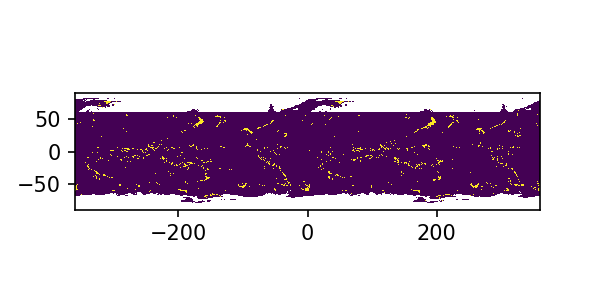

In [28]:
fig = plt.figure(figsize=(4, 2), dpi=150)
ax = fig.add_subplot(111)

#m = Basemap(projection='cyl')
#m.drawcoastlines(0.1)

plot_data = data
im = ax.imshow(plot_data[0], 
#                cmap='tab10',
                interpolation='none',
                extent=[-360, 360, -90,90])
#                extent=[-180, 180, -90,90])

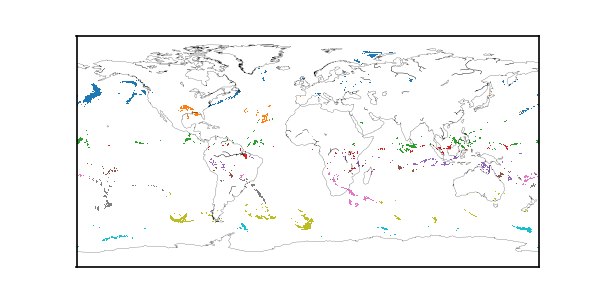

In [32]:
fig = plt.figure(figsize=(4, 2), dpi=150)
ax = fig.add_subplot(111)

m = Basemap(projection='cyl')
m.drawcoastlines(0.1)

plot_data = labels_out
im = ax.imshow(plot_data[0], 
                cmap='tab10',
                interpolation='none',
#                extent=[-360, 360, -90,90])
                extent=[-180, 180, -90,90])

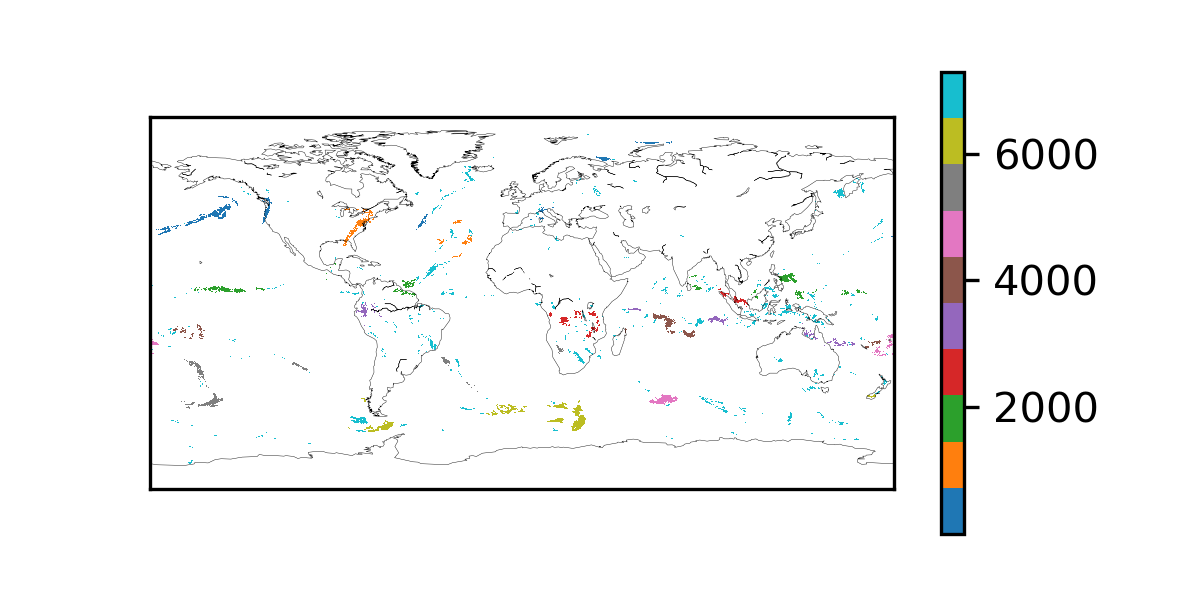

In [30]:
fig = plt.figure(figsize=(4, 2), dpi=300)
ax = fig.add_subplot(111)

m = Basemap(projection='cyl')
m.drawcoastlines(0.1)

plot_data = labels_out
im = ax.imshow(plot_data[0], 
                cmap='tab10',
                interpolation='none',
#                extent=[-360, 360, -90,90])
                extent=[-180, 180, -90,90])

def animate(i):    
    im.set_array(plot_data[i])
    return [im]

anim = animation.FuncAnimation(fig,
                               animate,                                
                               frames=len(plot_data),
                               interval=100, # in ms
                               blit=True)

plt.colorbar(im, ax=ax, orientation='vertical')
anim.save('all.gif', fps=10)

## Plotting the largest

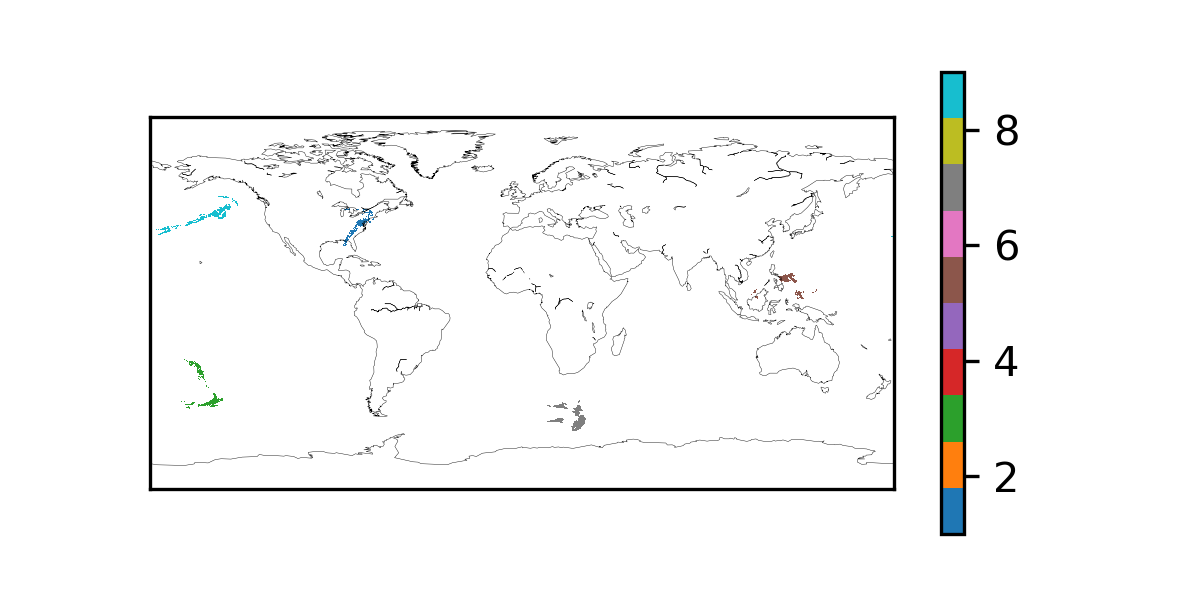

In [35]:
fig = plt.figure(figsize=(4,2), dpi=300)
ax = fig.add_subplot(111)

m = Basemap(projection='cyl')
m.drawcoastlines(0.1)

plot_data = largest
im = ax.imshow(plot_data[0], 
                cmap='tab10',
                interpolation='none',
                extent=[-180, 180, -90,90])

def animate(i):    
    im.set_array(plot_data[i])
    return [im]

anim = animation.FuncAnimation(fig,
                               animate,                                
                               frames=len(plot_data),
                               interval=100, # in ms
                               blit=True)

plt.colorbar(im, ax=ax, orientation='vertical')
anim.save('10_largest.gif', fps=10)